In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import pandas as pd
import seaborn as sns
from numba import njit, float64
from numba.experimental import jitclass
from matplotlib import cm

## Задача модели для работяг

#### Зададим функцию полезности

У нас есть наша исходная CRRA функция. Её проблема в том, что она не определена для σ=1. Но мы можем её достроить, посчитав следующий предел:

$$\lim _{{\sigma \rightarrow 1}}{\frac  {c^{{1-\sigma }}-1}{1-\sigma }}= \lim _{{\sigma \rightarrow 1}}{\frac  {\ln(c)(1-\sigma)}{1-\sigma }}=\ln(c)$$

In [2]:
def u(c, σ=1.4):
    if σ!=1:
        return (c**(1 - σ) - 1) / (1 - σ)
    else:
        return np.log(c) ### для σ=1 достраиваем логарифмом

In [3]:
n = 28                                 
dist_real = pd.read_excel('Tver_ob_prom.xlsx')/100 # подгрузим наши данные

In [4]:
# здесь немного пошаманим с исходной табличкой, чтобы получить вместо текста в столбцах не промежутки зп, а их медианы
# верхнюю границу возьмем 1 200 000 руб. Можно и больше, конечно, но сильно большая зп поломает нам статистику
 
col_list = [5640]  
for col in dist_real.columns[1:19]:
    col_list.append((int(col.split('–')[1]) + int(col.split('–')[0]))/2)
for col in dist_real.columns[19:-1]:
    col = col.split(' ')[0]
    col_list.append((int(col.split('–')[1]) + int(col.split('–')[0]))/2*1000)
col_list.append(1200000)
dist_real.columns = col_list

In [5]:
w_default = np.array(dist_real.columns) # исходные зарплаты
q_default = dist_real.values # их вероятности реализации

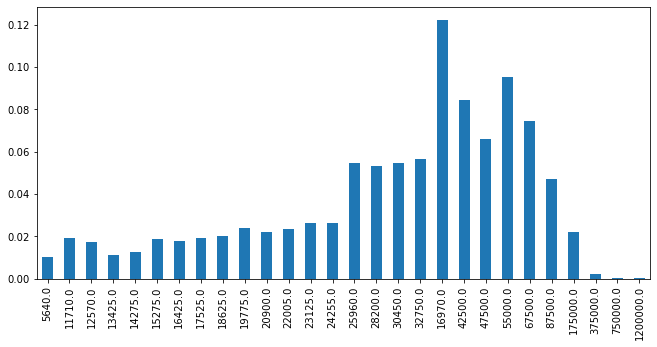

In [6]:
dist_real.T.plot(kind='bar', legend=False);

In [7]:
import scipy.stats
import numpy as np
hist = np.histogram(w_default, weights = q_default[0])
hist_dist = scipy.stats.rv_histogram(hist) # генерируем распределение из гистограммы

In [8]:
hist_dist.rvs()

7242.853973223984

Для решения задачи "работяг" нам нужно максимизировать следующеее мат ожидание:

$${\mathbb E} \sum_{t=0}^\infty \beta^t u(y_t) \xrightarrow[]{} max$$

По сути это суммарная ожидаемая полезность, а задача потребителя - это её максимизация. Время в этой задаче дискретное.

-	$v(w_e)$ - "пожизненная" полезность от ожидаемой заработной платы $w_e$, если индивид в текущем периоде работает
-	$h(w)$ - "пожизненная" полезность от предлагаемой в оффере заработной платы $w$, если индивид в текущем периоде не работает

$v(w_e) = u(w_e) + \beta
    \left[
        (1-\alpha)v(w_e) + \alpha \sum_{w' \in \mathbb W} h(w') q(w')
    \right]$ индивид работает, поэтому с вероятностью $1-\alpha$ он будет снова рекурсивно оказываться в ситуации $v(w_e)$ и с вероятностью $\alpha$ его уволят и тогда он переходит в ситуацию $h(w)$
    

$ h(w) = \max \left\{ v(w), \,  u(c) + \beta \sum_{w' \in \mathbb W} h(w') q(w') \right\}$ индивид выбирает между полезностью от заработной платы в оффере и полезностью от продолжения получения пособия (не работы)

Введем следующее обозначение:
$d = \sum_{w' \in \mathbb W} h(w') q(w') = \sum_{w' \in \mathbb W} \max \left\{ v(w'), \,  u(c) + \beta d \right\} q(w')$

Тогда, преобразовав выражение для $v(w_e)$ получим: $v(w_e) = u(w_e) + \beta
    \left[
        (1-\alpha)v(w_e) + \alpha d
    \right]$
    
Из этих двух уравнений Беллмана выведем резервную заработную плату (з/п, при которой индивиду безралично работать или нет, т.е. $v(\bar w) =  u(c) + \beta d$): 

Решить их можно двумя способами: аналитическим (при помощи оператора T) или подбором с заданной точностью (это мы и сделаем в коде)

Схема алгоритма:

1. Сделаем предположение о $d$ и $v$

2. Подставим их в исходные уравнения и получим $d'$ и $v'$

3. Сравним их максимальное отклонение друг от друга с заданной точностью (ошибкой). Если отклонение больше ошибки, то переобозначим $d = d'$ и $v = v'$. Так повторяем до тех пор, пока мы не перестанем превышать заданную точность, т.е. пока не сойдемся к ответу.

4. Выводим наши $d$ и $v$

#### Параметры модели

Пару слов про дисконт фактор. Обычно в качестве β берут $\frac{1}{1+r}$, поэтому мы тоже возьмем также

Что касается пособия по безработице $c$. Максимальный размер пособия в 2019 году был 8 000 руб., эту сумму мы и возьмем в качестве $c$.

In [9]:
1/(1+0.07) # (в 2019 году r варирьировалась от 7.75 до 6.25%, возьмем среднее)

0.9345794392523364

In [10]:
mccall_data = [
    ('α', float64),      # вероятность увольнения
    ('β', float64),      # дисконт фактор
    ('c', float64),      # пособие по безработице
    ('w', float64[:]),   # зарплаты
    ('q', float64[:]),   # вероятности
    ('σ', float64)       # параметр функции полезности
]

class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self, α=0.0, β=0.935, c=8000, w=w_default, q=q_default, σ = 1.4): # здесь задаем параметры исходной модели
        self.α, self.β, self.c, self.w, self.q, self.σ = α, β, c, w, q, σ


    def update(self, v, d):

        α, β, c, w, q, σ = self.α, self.β, self.c, self.w, self.q, self.σ

        v_new = np.empty_like(v)

        for i in range(len(w)):
            v_new[i] = u(w[i],σ) + β * ((1 - α) * v[i] + α * d)

        d_new = np.sum(np.maximum(v, u(c,σ) + β * d) * q)

        return v_new, d_new

In [11]:
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    * mcm is an instance of McCallModel
    """

    v = np.ones_like(mcm.w)    # изначальное предположение о v
    d = 1                      # изначальное предположение о d
    i = 0
    error = tol + 1

    while error > tol and i < max_iter: # пока разность превышает ошибку продолжаем перебирать v и d
        v_new, d_new = mcm.update(v, d)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(d_new - d)
        error = max(error_1, error_2)
        v = v_new
        d = d_new
        i += 1

    return v, d

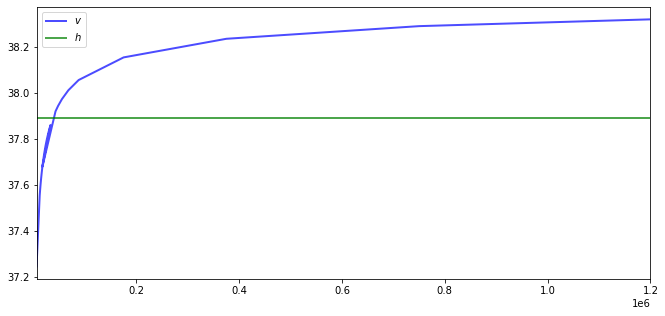

In [12]:
mcm = McCallModel()
v, d = solve_model(mcm)
h = u(mcm.c) + mcm.β * d

fig, ax = plt.subplots()

ax.plot(mcm.w, v, 'b-', lw=2, alpha=0.7, label='$v$')
ax.plot(mcm.w, [h] * len(mcm.w),
        'g-', lw=2, alpha=0.7, label='$h$')
ax.set_xlim(min(mcm.w), max(mcm.w))
ax.legend()

plt.show()

In [13]:
def compute_reservation_wage(mcm):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) >= h.

    If no such w exists, then w_bar is set to np.inf.
    """

    v, d = solve_model(mcm)
    h = u(mcm.c) + mcm.β * d

    w_bar = np.inf
    for i, wage in enumerate(mcm.w):
        if v[i] > h:
            w_bar = wage
            break

    return w_bar

### Графики

In [14]:
grid_size = 25
c_vals = np.linspace(6000, 50000, grid_size)   
beta_vals = np.linspace(0.85, 0.99, grid_size) 
alpha_vals = np.linspace(0.01, 0.5, grid_size)
sigma_vals = np.linspace(0.2, 2, grid_size)

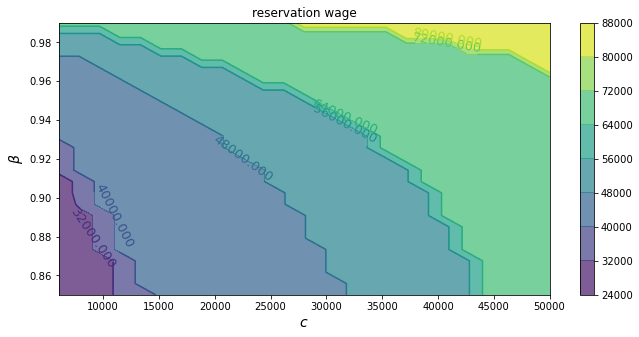

In [15]:
R = np.empty((grid_size, grid_size))
for i, c in enumerate(c_vals):
    for j, β in enumerate(beta_vals):
        mcm = McCallModel(c=c, β=β)
        R[i, j] = compute_reservation_wage(mcm)
        
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, beta_vals, R.T, alpha=0.7)
ctr1 = ax.contour(c_vals, beta_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=14)
ax.set_ylabel("$β$", fontsize=14)

ax.ticklabel_format(useOffset=False)

plt.show()

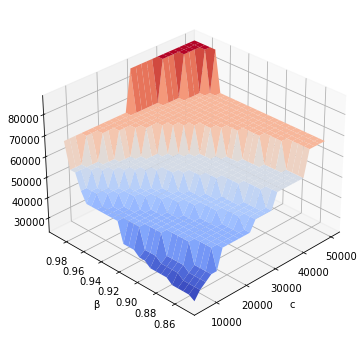

In [16]:
# Чем выше размер компенсации, тем выше индивид будет просить зарплату (т.е. резервная зп увеличивается), т.к. 
# если ему дают достаточно денег "просто так", то зачем ему идти работать :)

# Чем выше размер дисконт фактор, тем выше индивид будет просить зарплату (т.е. резервная зп увеличивается), т.к. 
# если он сильнее ценит будущее (чем ближе β к 1), то он будет ждать более высокую зп (т.к. оффер есть всегда)

# Максимальная резервная зп будет при максимальных дисконт факторе и компенсации, а минимум - при минимальных b и с.

mcm = McCallModel()
v, d = solve_model(mcm)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
cg, bg = np.meshgrid(c_vals, beta_vals)
ax.plot_surface(cg, bg, R.T,
                cmap=cm.coolwarm,
                linewidth=0.5)
ax.set(xlabel='c', ylabel='β')
ax.view_init(ax.elev, 225)
plt.show()

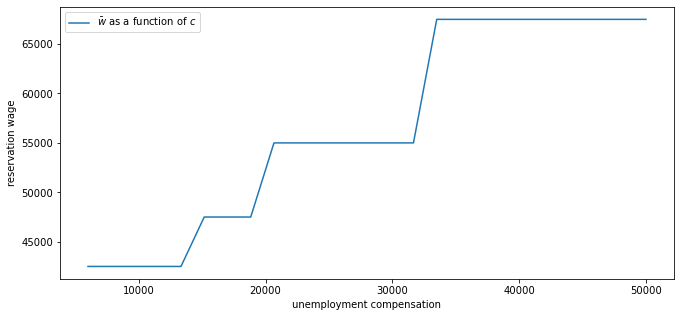

In [17]:
# Чем выше размер компенсации, тем выше индивид будет просить зарплату (т.е. резервная зп увеличивается), т.к. 
# если ему дают достаточно денег "просто так", то зачем ему идти работать :)

mcm = McCallModel()

w_bar_vals = np.empty_like(c_vals)

fig, ax = plt.subplots()

for i, c in enumerate(c_vals):
    mcm.c = c
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='unemployment compensation',
       ylabel='reservation wage')
ax.plot(c_vals, w_bar_vals, label=r'$\bar w$ as a function of $c$')
ax.legend()

plt.show()

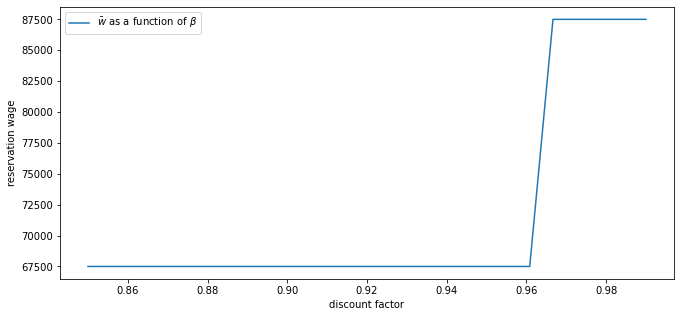

In [18]:
# Чем выше размер дисконт фактор, тем выше индивид будет просить зарплату (т.е. резервная зп увеличивается), т.к. 
# если он сильнее ценит будущее (чем ближе β к 1), то он будет ждать более высокую зп (т.к. оффер есть всегда)

fig, ax = plt.subplots()

for i, β in enumerate(beta_vals):
    mcm.β = β
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='discount factor', ylabel='reservation wage')
ax.plot(beta_vals, w_bar_vals, label=r'$\bar w$ as a function of $\beta$')
ax.legend()

plt.show()

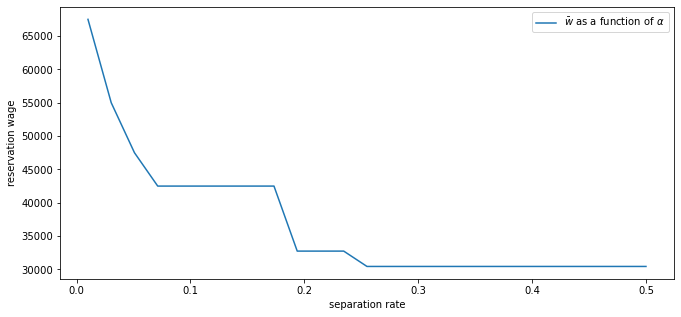

In [19]:
# Чем выше вероятность увольнения, тем ниже будет зарплата, на которую согласится индивид (т.е. резервная зп уменьшается), 
# т.к. если он боится, что его уволят (чем ближе β к 1), то он будет соглашаться на более низкую зарплату

fig, ax = plt.subplots()

for i, α in enumerate(alpha_vals):
    mcm.α = α
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='separation rate', ylabel='reservation wage')
ax.plot(alpha_vals, w_bar_vals, label=r'$\bar w$ as a function of $\alpha$')
ax.legend()

plt.show()

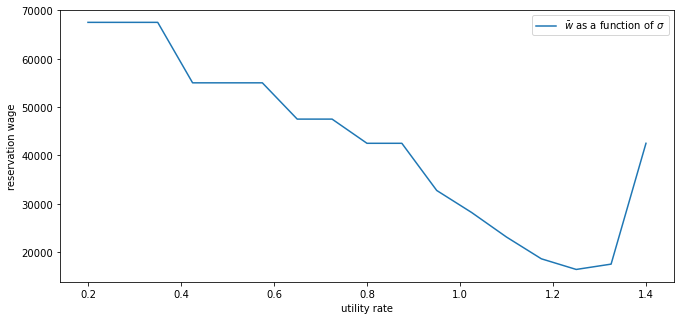

In [20]:
# до 1.25 резервная заработная плата падает по сигме, затем начинает возрастать и уходит на бесконечность,
# т.к. меняется характер функции полезности (сначала индивид получает большую полезность от меньшей резервной зп, 
# затем меньшую)
mcm = McCallModel()
fig, ax = plt.subplots()

for i, σ in enumerate(sigma_vals):
    mcm.σ = σ
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='utility rate', ylabel='reservation wage')
ax.plot(sigma_vals, w_bar_vals, label=r'$\bar w$ as a function of $\sigma$')
ax.legend()

plt.show()

## Advanced задача модели для работяг

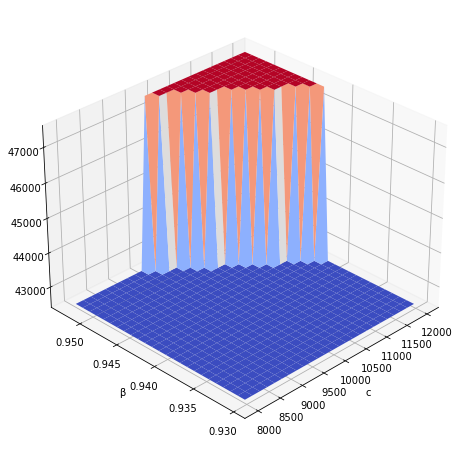

47500.0


In [21]:
grid_size = 25
c_vals = np.linspace(8000, 12000, grid_size)  # посмотрим, что будет, если будем увеличивать размер пособия, 
                                                # т.к. уменьшать его бессмысленно (резервная зп будет минимальна при с=0+)
beta_vals = 1/(0.05*c_vals/8000+1)

R = np.empty((grid_size, grid_size))
for i, c in enumerate(c_vals):
    for j, β in enumerate(beta_vals):
        mcm = McCallModel(c=c, β=β)
        R[i, j] = compute_reservation_wage(mcm)
        
mcm = McCallModel()
v, d = solve_model(mcm)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
cg, bg = np.meshgrid(c_vals, beta_vals)
ax.plot_surface(cg, bg, R.T,
                cmap=cm.coolwarm,
                linewidth=0.5)
ax.set(xlabel='c', ylabel='β')
ax.view_init(ax.elev, 225)
plt.show()

mcm = McCallModel(c=23000, β=1/(0.03*23000/8000+1)) # возьмем одно из решений задачи минимизации резервной зп (r=8.6%)
print(compute_reservation_wage(mcm))

In [22]:
c_init = 8000
mcm = McCallModel()
w_bar_init = compute_reservation_wage(mcm)

result = {c_init: w_bar_init}
step = 500

for _ in range(100):
    c_init = c_init + step
    β_init=1/(0.05*c_init/8000+1)
    mcm = McCallModel(c=c_init, β=β_init)
    w_bar_init = compute_reservation_wage(mcm)
    result[c_init] = w_bar_init

pd.Series(result) # перебираем размеры пособия и видим, что с его увеличением растет и резервная зп, поэтому берем
                    # минимальное пособие, которое дает нам новую резервную зп (брать то с, которое дает такую же w, как
                        # в исходной модели не имеет смысла, т.к. задача просто не изменится)

8000     42500.0
8500     42500.0
9000     42500.0
9500     42500.0
10000    42500.0
          ...   
56000    67500.0
56500    67500.0
57000    67500.0
57500    67500.0
58000    67500.0
Length: 101, dtype: float64

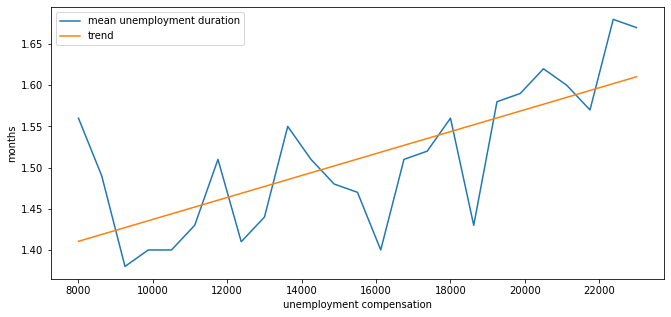

In [23]:
def compute_stopping_time(w_bar):
    t = 1
    while True:
        w = hist_dist.rvs() # выбираем случайные зарплаты из нашего распределения
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

def compute_mean_stopping_time(w_bar, num_reps=100): # 100 периодов
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar)
    return obs.mean()

c_vals = np.linspace(8000, 23000, 25) # задаем размеры пособия
stop_times = np.empty_like(c_vals)

for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    w_bar = compute_reservation_wage(mcm)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fit = np.polyfit(c_vals, stop_times, deg=1)
fit_function = np.poly1d(fit)

fig, ax = plt.subplots()
ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.plot(c_vals, fit_function(c_vals), label="trend")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()

In [24]:
c=8000 # задаем размеры пособия
mcm = McCallModel(c=c)
w_bar = compute_reservation_wage(mcm)
compute_mean_stopping_time(w_bar) # среднее число периодов, которое индивид не работает

1.47

In [25]:
c=23000 # задаем размеры пособия
mcm = McCallModel(c=c)
w_bar = compute_reservation_wage(mcm)
compute_mean_stopping_time(w_bar) # среднее число периодов, которое индивид не работает

1.51

Политика государства в данном случае не эффективна, т.к. увеличение размера пособия в среднем только увеличивает продолжительность безработицы. Это можно увидеть на графике (возрастающий тренд)

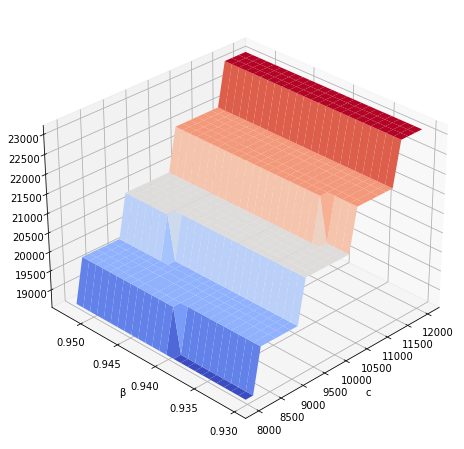

In [26]:
# Теперь возьмем ненулевую вероятность увольнения, например α = 0.25
grid_size = 25
c_vals = np.linspace(8000, 12000, grid_size)  # посмотрим, что будет, если будем увеличивать размер пособия, 
                                                # т.к. уменьшать его бессмысленно (резервная зп будет минимальна при с=0+)
beta_vals = 1/(0.05*c_vals/8000+1)

R = np.empty((grid_size, grid_size))
for i, c in enumerate(c_vals):
    for j, β in enumerate(beta_vals):
        mcm = McCallModel(c=c, β=β, α = 0.25)
        R[i, j] = compute_reservation_wage(mcm)
        
mcm = McCallModel()
v, d = solve_model(mcm)

fig = plt.figure(figsize=(10, 8)) # график поменялся; видно, что теперь от b практически ничего не зависит
ax = fig.add_subplot(111, projection='3d')
cg, bg = np.meshgrid(c_vals, beta_vals)
ax.plot_surface(cg, bg, R.T,
                cmap=cm.coolwarm,
                linewidth=0.5)
ax.set(xlabel='c', ylabel='β')
ax.view_init(ax.elev, 225)
plt.show()

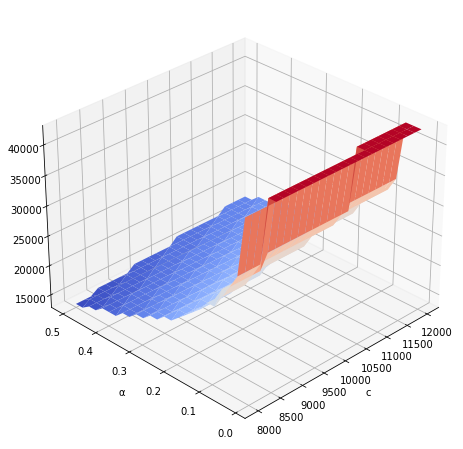

In [27]:
# попробуем поберебирать альфы вместо бет
grid_size = 25
c_vals = np.linspace(8000, 12000, grid_size)  # посмотрим, что будет, если будем увеличивать размер пособия, 
                                                # т.к. уменьшать его бессмысленно (резервная зп будет минимальна при с=0+)
alpha_vals = np.linspace(0.01, 0.5, grid_size)

R = np.empty((grid_size, grid_size))
for i, c in enumerate(c_vals):
    for j, α in enumerate(alpha_vals):
        mcm = McCallModel(c=c, α = α)
        R[i, j] = compute_reservation_wage(mcm)
        
mcm = McCallModel()
v, d = solve_model(mcm)

fig = plt.figure(figsize=(10, 8)) # теперь по c нет выраженного возрастающего тренда, что логично, т.к. вероятность 
                                  # увольнения повышает риск и снижает запросы индивида, т.е. снижает резервную зп
                                  # если вклад этого фактора (α) будет превалировать, то итоговая функция резевной зп
                                  # может убывать по пособию по безработице
ax = fig.add_subplot(111, projection='3d')
cg, bg = np.meshgrid(c_vals, alpha_vals)
ax.plot_surface(cg, bg, R.T,
                cmap=cm.coolwarm,
                linewidth=0.4)
ax.set(xlabel='c', ylabel='α')
ax.view_init(ax.elev, 225)
plt.show()

In [28]:
c_init = 8000
mcm = McCallModel(α = 0.25)
w_bar_init = compute_reservation_wage(mcm)

result = {c_init: w_bar_init}
step = 500

for _ in range(100):
    c_init = c_init + step
    β_init=1/(0.05*c_init/8000+1)
    mcm = McCallModel(c=c_init, β=β_init,α = 0.25)
    w_bar_init = compute_reservation_wage(mcm)
    result[c_init] = w_bar_init

print(pd.Series(result)) # перебираем размеры пособия и видим, что с его увеличением растет и резервная зп, поэтому берем
                         # минимальное пособие, которое дает нам новую резервную зп (брать то с, которое дает такую же w, как
                         # в исходной модели не имеет смысла, т.к. задача просто не изменится)
        
mcm = McCallModel(c=8500, β=1/(0.05*8500/8000+1),α = 0.25) # возьмем одно из решений задачи минимизации резервной зп (r=5.3%)
print(compute_reservation_wage(mcm))

8000     18625.0
8500     19775.0
9000     19775.0
9500     20900.0
10000    20900.0
          ...   
56000    67500.0
56500    67500.0
57000    67500.0
57500    67500.0
58000    67500.0
Length: 101, dtype: float64
19775.0


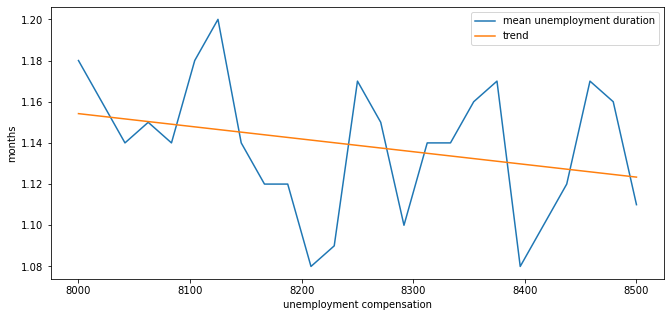

In [34]:
c_vals = np.linspace(8000, 8500, 25) # задаем размеры пособия
stop_times = np.empty_like(c_vals)

for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c, α = 0.25)
    w_bar = compute_reservation_wage(mcm)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fit = np.polyfit(c_vals, stop_times, deg=1)
fit_function = np.poly1d(fit)

fig, ax = plt.subplots()
ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.plot(c_vals, fit_function(c_vals), label="trend") # линия тренда в этом случае иногда имеет отрицательный наклон!
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()

In [30]:
c=8000 # задаем размеры пособия
mcm = McCallModel(c=c, α = 0.25)
w_bar = compute_reservation_wage(mcm)
compute_mean_stopping_time(w_bar) # среднее число периодов, которое индивид не работает (меньше, чем при α = 0)

1.09

In [31]:
c=8500 # задаем размеры пособия
mcm = McCallModel(c=c, α = 0.25)
w_bar = compute_reservation_wage(mcm)
compute_mean_stopping_time(w_bar) # среднее число периодов, которое индивид не работает (меньше, чем при α = 0)

1.08

При ненулевой вероятности увольнения индивид в среднем остается безработным меньше, чем при нулевой вероятности увольнения. В этом случае, если размер пособия будет отрицательно влиять на резервную зароботную плату, то политику государства можно назвать эффективной, т.к. тренд безработицы по размеру пособия будет отрицательным.